In [37]:
import numpy as np
from NPDoseResponse import DerivEffect, IntegEst, LocalPolyReg, LocalPolyReg1D, RoTBWLocalPoly
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import pandas as pd
import ray
import pickle
import seaborn as sns
from utils import RoTBWLocalPoly_Old

In [38]:
PM25_CMR = pd.read_csv("./SES_PM25_CMR_data/County_annual_PM25_CMR.csv")
PM25_CMR = PM25_CMR.iloc[:,1:]
PM25_CMR

,FIPS,Year,PM2.5,CMR
0,1001,1990,9.749792,471.758888
1,1001,1991,9.069443,456.869651
2,1001,1992,9.105352,520.014377
3,1001,1993,8.752873,454.436425
4,1001,1994,9.024049,415.035332
...,...,...,...,...
44767,56037,2006,3.776910,247.510138
44768,56037,2007,3.609803,292.450269
44769,56037,2008,3.297100,182.189745
44770,56037,2009,3.119896,242.828987


In [3]:
county_RAW = pd.read_csv("./SES_PM25_CMR_data/County_RAW_variables.csv")
county_RAW = county_RAW.iloc[:,1:]
county_RAW

,FIPS,civil_unemploy_1990,civil_unemploy_2000,civil_unemploy_2010,median_HH_inc_1990,median_HH_inc_2000,median_HH_inc_2010,femaleHH_ns_pct_1990,femaleHH_ns_pct_2000,femaleHH_ns_pct_2010,...,eduattain_HS_1990,eduattain_HS_2000,eduattain_HS_2010,pctfam_pover_1990,pctfam_pover_2000,pctfam_pover_2010,healthfac_1999,healthfac_2005,healthfac_2005_1999,population_2000
0,1001,6.6,3.1,6.2,28337,42013,53255,15.124724,13.1,13.7,...,70.0,33.8,35.2,12.024655,8.2,7.5,1.099128,1.465503,0.366376,43671
1,1003,5.3,2.6,6.6,25712,40250,50147,13.204463,10.2,11.1,...,73.2,29.6,29.9,10.438783,7.6,9.1,1.780437,2.428515,0.648079,140415
2,1005,7.9,2.7,9.6,19389,25101,33219,22.700763,19.1,19.8,...,55.6,32.4,35.4,20.020793,21.6,19.9,1.411943,1.515256,0.103313,29038
3,1009,6.4,2.9,7.5,22382,35241,45549,9.953664,7.9,9.7,...,60.5,36.0,36.4,11.379399,8.6,10.0,0.646754,0.764346,0.117592,51024
4,1011,12.6,3.6,11.2,14745,20605,31602,36.098820,28.2,26.8,...,49.0,35.2,36.6,31.397929,29.8,22.6,1.280519,1.365887,0.085368,11714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,56025,6.3,3.5,4.5,27586,36619,50936,13.868043,10.6,10.9,...,85.3,30.6,31.4,9.786297,8.7,5.4,2.855726,3.156328,0.300603,66533
2128,56027,3.9,2.1,2.5,20947,29701,45813,11.516035,6.0,7.4,...,75.7,38.9,32.8,13.362069,10.7,6.3,0.000000,0.000000,0.000000,2407
2129,56029,4.9,3.2,4.1,25942,35829,46637,9.949142,7.1,7.2,...,82.6,30.4,28.8,7.340895,8.4,5.5,2.365625,2.559528,0.193904,25786
2130,56033,5.8,2.9,3.0,24772,34538,48141,12.395915,8.2,8.4,...,81.6,28.8,31.1,7.376284,8.6,5.2,2.597892,3.162651,0.564759,26560


In [4]:
county_loc = pd.read_csv("./SES_PM25_CMR_data/us_county_latlng.csv")
county_loc

,fips_code,name,lng,lat
0,1059,Franklin,-87.843283,34.442381
1,13111,Fannin,-84.319296,34.864126
2,19109,Kossuth,-94.206898,43.204140
3,40115,Ottawa,-94.810589,36.835878
4,42115,Susquehanna,-75.800905,41.821277
...,...,...,...,...
3228,12029,Dixie,-83.158705,29.608068
3229,18017,Cass,-86.346207,40.761660
3230,26091,Lenawee,-84.066412,41.894694
3231,72003,Aguada,-67.175247,18.360392


In [5]:
merge_dat = PM25_CMR.merge(county_RAW, how='left', left_on='FIPS', right_on='FIPS')
merge_dat = merge_dat.merge(county_loc, how='left', left_on='FIPS', right_on='fips_code')
merge_dat

,FIPS,Year,PM2.5,CMR,civil_unemploy_1990,civil_unemploy_2000,civil_unemploy_2010,median_HH_inc_1990,median_HH_inc_2000,median_HH_inc_2010,...,pctfam_pover_2000,pctfam_pover_2010,healthfac_1999,healthfac_2005,healthfac_2005_1999,population_2000,fips_code,name,lng,lat
0,1001,1990,9.749792,471.758888,6.6,3.1,6.2,28337,42013,53255,...,8.2,7.5,1.099128,1.465503,0.366376,43671,1001,Autauga,-86.642900,32.535142
1,1001,1991,9.069443,456.869651,6.6,3.1,6.2,28337,42013,53255,...,8.2,7.5,1.099128,1.465503,0.366376,43671,1001,Autauga,-86.642900,32.535142
2,1001,1992,9.105352,520.014377,6.6,3.1,6.2,28337,42013,53255,...,8.2,7.5,1.099128,1.465503,0.366376,43671,1001,Autauga,-86.642900,32.535142
3,1001,1993,8.752873,454.436425,6.6,3.1,6.2,28337,42013,53255,...,8.2,7.5,1.099128,1.465503,0.366376,43671,1001,Autauga,-86.642900,32.535142
4,1001,1994,9.024049,415.035332,6.6,3.1,6.2,28337,42013,53255,...,8.2,7.5,1.099128,1.465503,0.366376,43671,1001,Autauga,-86.642900,32.535142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44767,56037,2006,3.776910,247.510138,5.5,4.0,4.7,36210,46537,69828,...,5.4,6.1,1.861059,2.153511,0.292452,37613,56037,Sweetwater,-108.879388,41.659762
44768,56037,2007,3.609803,292.450269,5.5,4.0,4.7,36210,46537,69828,...,5.4,6.1,1.861059,2.153511,0.292452,37613,56037,Sweetwater,-108.879388,41.659762
44769,56037,2008,3.297100,182.189745,5.5,4.0,4.7,36210,46537,69828,...,5.4,6.1,1.861059,2.153511,0.292452,37613,56037,Sweetwater,-108.879388,41.659762
44770,56037,2009,3.119896,242.828987,5.5,4.0,4.7,36210,46537,69828,...,5.4,6.1,1.861059,2.153511,0.292452,37613,56037,Sweetwater,-108.879388,41.659762


In [6]:
merge_dat.columns

Index(['FIPS', 'Year', 'PM2.5', 'CMR', 'civil_unemploy_1990',
       'civil_unemploy_2000', 'civil_unemploy_2010', 'median_HH_inc_1990',
       'median_HH_inc_2000', 'median_HH_inc_2010', 'femaleHH_ns_pct_1990',
       'femaleHH_ns_pct_2000', 'femaleHH_ns_pct_2010', 'vacant_HHunit_1990',
       'vacant_HHunit_2000', 'vacant_HHunit_2010', 'owner_occ_pct_1990',
       'owner_occ_pct_2000', 'owner_occ_pct_2010', 'eduattain_HS_1990',
       'eduattain_HS_2000', 'eduattain_HS_2010', 'pctfam_pover_1990',
       'pctfam_pover_2000', 'pctfam_pover_2010', 'healthfac_1999',
       'healthfac_2005', 'healthfac_2005_1999', 'population_2000', 'fips_code',
       'name', 'lng', 'lat'],
      dtype='object')

In [7]:
def TransVarByYear(x):
    if x["Year"] <= 1995:
        return x[1]
    elif x["Year"] >= 2005:
        return x[3]
    else:
        return x[2]

var_lst = ["civil_unemploy", "median_HH_inc", "femaleHH_ns_pct", "vacant_HHunit", "owner_occ_pct",
           "eduattain_HS", "pctfam_pover"]
for var in var_lst:
    org_var = ['Year']
    org_var.append(var+'_1990')
    org_var.append(var+'_2000')
    org_var.append(var+'_2010')
    merge_dat[var] = merge_dat[org_var].apply(lambda x: TransVarByYear(x), axis=1)

In [8]:
final_dat = merge_dat[['FIPS', 'Year', 'name', 'lng', 'lat', 'PM2.5', 'CMR', "population_2000", "civil_unemploy", 
                       "median_HH_inc", "femaleHH_ns_pct", "vacant_HHunit", "owner_occ_pct",
                       "eduattain_HS", "pctfam_pover"]]
final_dat

,FIPS,Year,name,lng,lat,PM2.5,CMR,population_2000,civil_unemploy,median_HH_inc,femaleHH_ns_pct,vacant_HHunit,owner_occ_pct,eduattain_HS,pctfam_pover
0,1001,1990,Autauga,-86.642900,32.535142,9.749792,471.758888,43671,6.6,28337,15.124724,7.115928,79.7,70.0,12.024655
1,1001,1991,Autauga,-86.642900,32.535142,9.069443,456.869651,43671,6.6,28337,15.124724,7.115928,79.7,70.0,12.024655
2,1001,1992,Autauga,-86.642900,32.535142,9.105352,520.014377,43671,6.6,28337,15.124724,7.115928,79.7,70.0,12.024655
3,1001,1993,Autauga,-86.642900,32.535142,8.752873,454.436425,43671,6.6,28337,15.124724,7.115928,79.7,70.0,12.024655
4,1001,1994,Autauga,-86.642900,32.535142,9.024049,415.035332,43671,6.6,28337,15.124724,7.115928,79.7,70.0,12.024655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44767,56037,2006,Sweetwater,-108.879388,41.659762,3.776910,247.510138,37613,4.7,69828,9.000000,12.100000,72.1,34.8,6.100000
44768,56037,2007,Sweetwater,-108.879388,41.659762,3.609803,292.450269,37613,4.7,69828,9.000000,12.100000,72.1,34.8,6.100000
44769,56037,2008,Sweetwater,-108.879388,41.659762,3.297100,182.189745,37613,4.7,69828,9.000000,12.100000,72.1,34.8,6.100000
44770,56037,2009,Sweetwater,-108.879388,41.659762,3.119896,242.828987,37613,4.7,69828,9.000000,12.100000,72.1,34.8,6.100000


In [50]:
dat = final_dat.groupby(['FIPS', 'name']).mean().reset_index()
final_dat.to_csv('PM25_county_CMR_final.csv', index=False)
dat.to_csv('PM25_county_CMR_avg.csv', index=False)
dat

,FIPS,name,Year,lng,lat,PM2.5,CMR,population_2000,civil_unemploy,median_HH_inc,femaleHH_ns_pct,vacant_HHunit,owner_occ_pct,eduattain_HS,pctfam_pover
0,1001,Autauga,2000.0,-86.642900,32.535142,8.267371,406.748880,43671.0,4.985714,41317.571429,13.849921,8.518837,78.942857,44.542857,9.092759
1,1003,Baldwin,2000.0,-87.722745,30.727825,6.753971,319.406347,140415.0,4.514286,38924.000000,11.315561,27.205474,77.185714,42.142857,8.839652
2,1005,Barbour,2000.0,-85.391068,31.870090,7.282907,401.875134,29038.0,6.157143,25788.428571,20.328789,15.897344,70.528571,39.885714,20.663084
3,1009,Blount,2000.0,-86.567006,33.980871,9.747287,372.962349,51024.0,5.214286,34512.142857,9.001047,8.659359,82.142857,43.114286,9.794114
4,1011,Bullock,2000.0,-85.715729,32.100459,8.133036,408.763903,11714.0,8.342857,22072.714286,30.056806,15.771884,72.185714,39.542857,28.199408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,56025,Natrona,2000.0,-106.798876,42.961940,3.033695,276.577034,66533.0,4.585714,38128.714286,11.619441,12.252917,69.728571,46.457143,8.067513
2128,56027,Niobrara,2000.0,-104.475596,43.056170,3.193389,279.959689,2407.0,2.728571,31803.285714,7.976010,24.520251,72.214286,47.671429,10.203448
2129,56029,Park,2000.0,-109.588595,44.520535,2.744854,260.269591,25786.0,3.942857,36092.142857,7.942612,13.451451,70.200000,44.857143,7.268827
2130,56033,Sheridan,2000.0,-106.879955,44.790680,2.793528,303.414827,26560.0,3.757143,35634.285714,9.455976,12.454914,68.728571,44.542857,7.278938


In [51]:
# df = dat.loc[[10,23,28,30,100,180], ['FIPS', 'name', 'lng', 'lat', 'PM2.5', 'CMR']]
# df.columns = ['FIPS', 'County name', 'Longitude', 'Latitude', 'PM2.5', 'CMR']
# df

In [10]:
final_dat.to_csv('PM25_county_CMR_final.csv', index=False)

In [11]:
dat = pd.read_csv('PM25_county_CMR_avg.csv')
dat
X = dat[['PM2.5', 'lng', 'lat']].values
Y = dat['CMR'].values
print(min(dat['PM2.5']))
print(max(dat['PM2.5']))
dat.columns

2.344634487564427
12.360138870315682


Index(['FIPS', 'name', 'Year', 'lng', 'lat', 'PM2.5', 'CMR', 'population_2000',
       'civil_unemploy', 'median_HH_inc', 'femaleHH_ns_pct', 'vacant_HHunit',
       'owner_occ_pct', 'eduattain_HS', 'pctfam_pover'],
      dtype='object')

In [12]:
# plt.rcParams.update({'font.size': 16})  ## Change the font sizes of ouput figures
# plt.figure(figsize=(8,5))
# m1 = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# x, y = m1(dat.lng, dat.lat)
# # m1.drawcoastlines()
# # m1.drawcountries()
# # m1.drawstates()
# # cs = m.scatter(x, y)
# cs = m1.contourf(x, y, data=z, cmap='OrRd')
# plt.tight_layout()
# plt.show()

### Effect of fine particulate matter on cardiovascular mortality

#### Regress Y on T and spatial locations

In [13]:
n = dat.shape[0]
T = dat['PM2.5'].values
X = dat[['PM2.5', 'lng', 'lat']].values
Y = dat['CMR'].values
t_qry = np.linspace(min(T)+0.01, max(T)-0.01, 200)

In [14]:
# h_cur, b_cur = RoTBWLocalPoly(Y, X, kernT="epanechnikov", kernS="epanechnikov", 
#                                   C_h=16*np.std(T), C_b=23*np.std(X[:,1:], axis=0))
# print(h_cur, b_cur)

# h_cur2, b_cur2 = RoTBWLocalPoly_Old(Y, X, kernT="epanechnikov", kernS="epanechnikov",
#                                      C_h=7*np.std(T), C_b=20*np.std(X[:,1:], axis=0))
# h_cur2, b_cur2

In [16]:
with open('./Syn_Results/PM25_App_TS_new_bw.dat', "rb") as file:
    theta_est1, m_est1, Y_RA1, Y_RA_deriv1, theta_est_boot_arr1, m_est_boot_arr1, \
    Y_RA_deriv_boot_arr1, Y_RA_boot_arr1 = pickle.load(file)
theta_boot_sup1 = np.max(np.abs(theta_est_boot_arr1 - theta_est1), axis=1)
m_boot_sup1 = np.max(np.abs(m_est_boot_arr1 - m_est1), axis=1)

theta_alpha1 = np.quantile(theta_boot_sup1, 0.95)
m_alpha1 = np.quantile(m_boot_sup1, 0.95)
print(theta_alpha1)
m_alpha1

11.815987960537349


17.31734934290577

In [17]:
theta_boot_abs1 = np.abs(theta_est_boot_arr1 - theta_est1)
m_boot_abs1 = np.abs(m_est_boot_arr1 - m_est1)

theta_alpha_var1 = np.quantile(theta_boot_abs1, 0.95, axis=0)
m_alpha_var1 = np.quantile(m_boot_abs1, 0.95, axis=0)

In [18]:
# t_qry = np.linspace(min(T)+0.01, max(T)-0.01, 200)

# plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
# plt.figure(figsize=(14,8))
# plt.subplot(121)
# plt.scatter(t_qry, Y_RA_deriv1, color='orange', label=r'Estimated $\hat{\theta}_{RA}(t)$')
# plt.scatter(t_qry, theta_est1, color='green', label=r'Estimated $\hat{\theta}_C(t)$')
# plt.fill_between(t_qry, theta_est1 - theta_alpha_var1, theta_est1 + theta_alpha_var1, color='g', 
#                  alpha=.3, label='95% pointwise confidence intervals')
# plt.plot(t_qry, theta_est1 - theta_alpha1, linestyle='dashed', color='black', linewidth=2)
# plt.plot(t_qry, theta_est1 + theta_alpha1, linestyle='dashed', color='black', linewidth=2,
#          label='95% uniform confidence band')
# plt.legend()
# plt.xlabel('T')
# plt.ylabel(r'$\theta(t)$')
# plt.title("Include only T and S")

# plt.subplot(122)
# # plt.scatter(T, Y, facecolors='none', edgecolors='black', alpha=0.5, label='Noisy data points')
# # sns.rugplot(T, height=0.025, color='grey')
# plt.scatter(t_qry, Y_RA1, color='purple', label=r'Estimated $\hat{m}_{RA}(t)$')
# plt.scatter(t_qry, m_est1, color='blue', label=r'Estimated $\hat{m}_{\theta}(t)$')
# plt.fill_between(t_qry, m_est1 - m_alpha_var1, m_est1 + m_alpha_var1, color='b', 
#                  alpha=.3, label='95% Pointwise CIs')
# plt.plot(t_qry, m_est1 - m_alpha1, linestyle='dashed', color='black', linewidth=2)
# plt.plot(t_qry, m_est1 + m_alpha1, linestyle='dashed', color='black', linewidth=2,
#          label='95% uniform confidence band')
# plt.legend()
# plt.ylim(280, 390)
# plt.xlabel('T')
# plt.ylabel(r'$m(t)$')
# plt.title("Include only T and S")
# plt.show()

#### Focus on the PM 2.5 range:  2.5 μg/m3 --11.5 μg/m3

In [19]:
# Focus on the range 2.5--11.5
cri_in = (t_qry >= 2.5) & (t_qry <= 11.5)

with open('./Syn_Results/PM25_App_TS_new_bw.dat', "rb") as file:
    theta_est1, m_est1, Y_RA1, Y_RA_deriv1, theta_est_boot_arr1, m_est_boot_arr1, \
    Y_RA_deriv_boot_arr1, Y_RA_boot_arr1 = pickle.load(file)
    
theta_boot_sup1 = np.max(np.abs(theta_est_boot_arr1 - theta_est1)[:,cri_in], axis=1)
m_boot_sup1 = np.max(np.abs(m_est_boot_arr1 - m_est1)[:,cri_in], axis=1)

theta_alpha1r = np.quantile(theta_boot_sup1, 0.95)
m_alpha1r = np.quantile(m_boot_sup1, 0.95)
print(theta_alpha1r)
m_alpha1r

8.161161472721059


12.948747137208983

In [20]:
theta_boot_abs1 = np.abs(theta_est_boot_arr1 - theta_est1)
m_boot_abs1 = np.abs(m_est_boot_arr1 - m_est1)

theta_alpha_var1r = np.quantile(theta_boot_abs1, 0.95, axis=0)[cri_in]
m_alpha_var1r = np.quantile(m_boot_abs1, 0.95, axis=0)[cri_in]

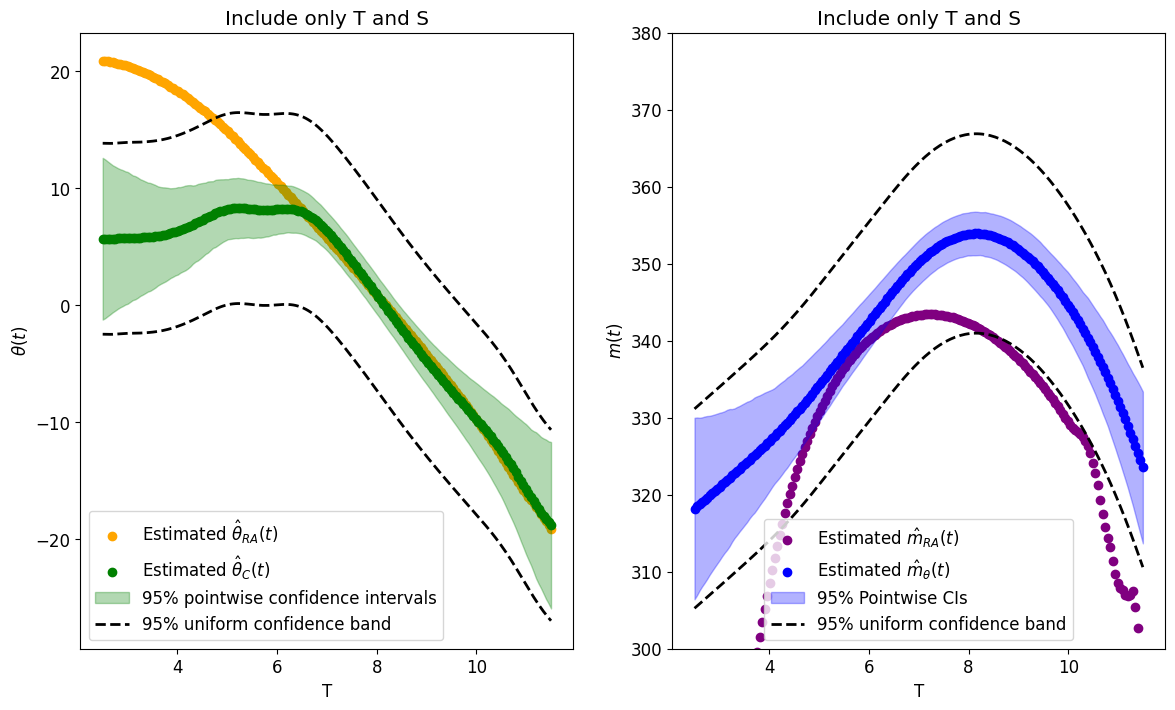

In [21]:
theta_est1r = theta_est1[cri_in]
m_est1r = m_est1[cri_in]
t_qry1r = t_qry[cri_in]
Y_RA1r = Y_RA1[cri_in]
Y_RA_deriv1r = Y_RA_deriv1[cri_in]

plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.scatter(t_qry1r, Y_RA_deriv1r, color='orange', label=r'Estimated $\hat{\theta}_{RA}(t)$')
plt.scatter(t_qry1r, theta_est1r, color='green', label=r'Estimated $\hat{\theta}_C(t)$')
plt.fill_between(t_qry1r, theta_est1r - theta_alpha_var1r, theta_est1r + theta_alpha_var1r, color='g', 
                 alpha=.3, label='95% pointwise confidence intervals')
plt.plot(t_qry1r, theta_est1r - theta_alpha1r, linestyle='dashed', color='black', linewidth=2)
plt.plot(t_qry1r, theta_est1r + theta_alpha1r, linestyle='dashed', color='black', linewidth=2,
         label='95% uniform confidence band')
plt.legend()
plt.xlabel('T')
plt.ylabel(r'$\theta(t)$')
plt.title("Include only T and S")

plt.subplot(122)
# plt.scatter(T, Y, facecolors='none', edgecolors='black', alpha=0.5, label='Noisy data points')
# sns.rugplot(T, height=0.025, color='grey')
plt.scatter(t_qry1r, Y_RA1r, color='purple', label=r'Estimated $\hat{m}_{RA}(t)$')
plt.scatter(t_qry1r, m_est1r, color='blue', label=r'Estimated $\hat{m}_{\theta}(t)$')
plt.fill_between(t_qry1r, m_est1r - m_alpha_var1r, m_est1r + m_alpha_var1r, color='b', 
                 alpha=.3, label='95% Pointwise CIs')
plt.plot(t_qry1r, m_est1r - m_alpha1r, linestyle='dashed', color='black', linewidth=2)
plt.plot(t_qry1r, m_est1r + m_alpha1r, linestyle='dashed', color='black', linewidth=2,
         label='95% uniform confidence band')
plt.legend()
plt.ylim(300, 380)
plt.xlabel('T')
plt.ylabel(r'$m(t)$')
plt.title("Include only T and S")
plt.show()

### Regress Y on T only

In [21]:
# t_qry = np.linspace(min(T)+0.01, max(T)-0.01, 200)
# Y_est_ll = LocalPolyReg1D(Y, T, h=7*np.std(T), x_eval=t_qry, degree=2, deriv_ord=0, kernel='epanechnikov')
# Y_deriv_t = LocalPolyReg1D(Y, T, h=7*np.std(T), x_eval=t_qry, degree=2, deriv_ord=1, kernel='epanechnikov')

# plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
# plt.figure(figsize=(14,6))
# plt.subplot(121)
# plt.scatter(t_qry, Y_deriv_t, color='green', label='Estimated derivative of Y against T')
# sns.rugplot(T, height=0.025, color='grey')
# plt.legend()
# plt.xlabel('T')
# plt.ylabel(r"$m'(t)$ by ignoring spatial confounding")

# plt.subplot(122)
# plt.scatter(T, Y, facecolors='none', edgecolors='black', label='Noisy data points')
# plt.scatter(t_qry, Y_est_ll, color='blue', label='Estimated regression function of Y against T')
# plt.legend()
# plt.xlabel('T')
# plt.ylabel('Y')
# plt.show()

In [22]:
with open('./Syn_Results/PM25_App_Tonly_new_bw.dat', "rb") as file:
    theta_est2, m_est2, theta_est_boot_arr2, m_est_boot_arr2 = pickle.load(file)
    
theta_boot_sup2 = np.max(np.abs(theta_est_boot_arr2 - theta_est2), axis=1)
m_boot_sup2 = np.max(np.abs(m_est_boot_arr2 - m_est2), axis=1)

theta_alpha2 = np.quantile(theta_boot_sup2, 0.95)
m_alpha2 = np.quantile(m_boot_sup2, 0.95)
print(theta_alpha2)
m_alpha2

6.17783137009228


66.23492234910815

In [23]:
theta_boot_abs2 = np.abs(theta_est_boot_arr2 - theta_est2)
m_boot_abs2 = np.abs(m_est_boot_arr2 - m_est2)

theta_alpha_var2 = np.quantile(theta_boot_abs2, 0.95, axis=0)
m_alpha_var2 = np.quantile(m_boot_abs2, 0.95, axis=0)

In [24]:
# plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
# plt.figure(figsize=(14,8))
# plt.subplot(121)
# plt.scatter(t_qry, theta_est2, color='green', label=r'Estimated $\hat{\theta}_C(t)$')
# plt.fill_between(t_qry, theta_est2 - theta_alpha_var2, theta_est2 + theta_alpha_var2, color='g', 
#                  alpha=.3, label='95% pointwise confidence intervals')
# plt.plot(t_qry, theta_est2 - theta_alpha2, linestyle='dashed', color='black', linewidth=2)
# plt.plot(t_qry, theta_est2 + theta_alpha2, linestyle='dashed', color='black', linewidth=2,
#          label='95% uniform confidence band')
# plt.legend()
# plt.xlabel('T')
# plt.ylabel(r'$\theta(t)$')
# plt.title("Include only the treatment variable T")

# plt.subplot(122)
# # plt.scatter(T, Y, facecolors='none', edgecolors='black', alpha=0.5, label='Noisy data points')
# # sns.rugplot(T, height=0.025, color='grey')
# plt.scatter(t_qry, m_est2, color='blue', label=r'Estimated $\hat{m}_{\theta}(t)$')
# plt.fill_between(t_qry, m_est2 - m_alpha_var2, m_est2 + m_alpha_var2, color='b', 
#                  alpha=.3, label='95% Pointwise CIs')
# plt.plot(t_qry, m_est2 - m_alpha2, linestyle='dashed', color='black', linewidth=2)
# plt.plot(t_qry, m_est2 + m_alpha2, linestyle='dashed', color='black', linewidth=2,
#          label='95% uniform confidence band')
# plt.legend()
# # plt.xlim(-2, 3)
# plt.xlabel('T')
# plt.ylabel(r'$m(t)$')
# plt.title("Include only the treatment variable T")
# plt.show()

#### Focus on the PM 2.5 range:  2.5 μg/m3 --11.5 μg/m3

In [25]:
# Focus on the range 2.5--11.5
cri_in = (t_qry >= 2.5) & (t_qry <= 11.5)

with open('./Syn_Results/PM25_App_Tonly_new_bw.dat', "rb") as file:
    theta_est2, m_est2, theta_est_boot_arr2, m_est_boot_arr2 = pickle.load(file)
    
theta_boot_sup2 = np.max(np.abs(theta_est_boot_arr2 - theta_est2)[:,cri_in], axis=1)
m_boot_sup2 = np.max(np.abs(m_est_boot_arr2 - m_est2)[:,cri_in], axis=1)

theta_alpha2r = np.quantile(theta_boot_sup2, 0.95)
m_alpha2r = np.quantile(m_boot_sup2, 0.95)
print(theta_alpha2r)
m_alpha2r

4.911019507771051


45.11758932181901

In [26]:
theta_boot_abs2 = np.abs(theta_est_boot_arr2 - theta_est2)
m_boot_abs2 = np.abs(m_est_boot_arr2 - m_est2)

theta_alpha_var2r = np.quantile(theta_boot_abs2, 0.95, axis=0)[cri_in]
m_alpha_var2r = np.quantile(m_boot_abs2, 0.95, axis=0)[cri_in]

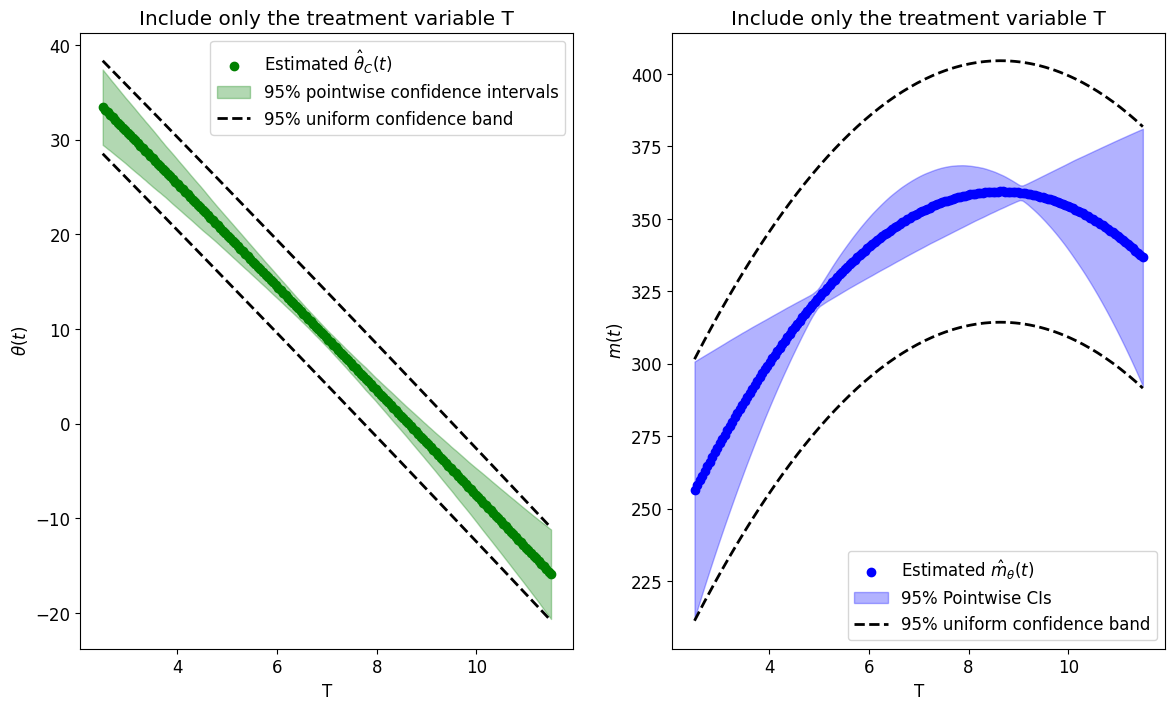

In [27]:
theta_est2r = theta_est2[cri_in]
m_est2r = m_est2[cri_in]
t_qry2r = t_qry[cri_in]

plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.scatter(t_qry2r, theta_est2r, color='green', label=r'Estimated $\hat{\theta}_C(t)$')
plt.fill_between(t_qry2r, theta_est2r - theta_alpha_var2r, theta_est2r + theta_alpha_var2r, color='g', 
                 alpha=.3, label='95% pointwise confidence intervals')
plt.plot(t_qry2r, theta_est2r - theta_alpha2r, linestyle='dashed', color='black', linewidth=2)
plt.plot(t_qry2r, theta_est2r + theta_alpha2r, linestyle='dashed', color='black', linewidth=2,
         label='95% uniform confidence band')
plt.legend()
plt.xlabel('T')
plt.ylabel(r'$\theta(t)$')
plt.title("Include only the treatment variable T")

plt.subplot(122)
# plt.scatter(T, Y, facecolors='none', edgecolors='black', alpha=0.5, label='Noisy data points')
# sns.rugplot(T, height=0.025, color='grey')
plt.scatter(t_qry2r, m_est2r, color='blue', label=r'Estimated $\hat{m}_{\theta}(t)$')
plt.fill_between(t_qry2r, m_est2r - m_alpha_var2r, m_est2r + m_alpha_var2r, color='b', 
                 alpha=.3, label='95% Pointwise CIs')
plt.plot(t_qry2r, m_est2r - m_alpha2r, linestyle='dashed', color='black', linewidth=2)
plt.plot(t_qry2r, m_est2r + m_alpha2r, linestyle='dashed', color='black', linewidth=2,
         label='95% uniform confidence band')
plt.legend()
# plt.xlim(-2, 3)
plt.xlabel('T')
plt.ylabel(r'$m(t)$')
plt.title("Include only the treatment variable T")
plt.show()

### Regress Y on T and all other covariates

In [28]:
dat = pd.read_csv('PM25_county_CMR_avg.csv')
n = dat.shape[0]
T = dat['PM2.5'].values
X = dat[['PM2.5', 'lng', 'lat', 'population_2000',
       'civil_unemploy', 'median_HH_inc', 'femaleHH_ns_pct', 'vacant_HHunit',
       'owner_occ_pct', 'eduattain_HS', 'pctfam_pover']].values
Y = dat['CMR'].values

t_qry = np.linspace(min(T)+0.01, max(T)-0.01, 200)

In [29]:
# h_cur, b_cur = RoTBWLocalPoly(Y, X, kernT="epanechnikov", kernS="epanechnikov", C_h=7*np.std(T), 
#                               C_b=20*np.std(X[:,1:], axis=0))

# Y_est = LocalPolyReg(Y, X, x_eval=None, degree=2, deriv_ord=0, h=h_cur, b=b_cur, 
#                      kernT="epanechnikov", kernS="epanechnikov")
# Y_est_deriv = LocalPolyReg(Y, X, x_eval=None, degree=2, deriv_ord=1, h=h_cur, b=b_cur, 
#                      kernT="epanechnikov", kernS="epanechnikov")

# plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
# plt.figure(figsize=(14,6))
# plt.subplot(121)
# plt.scatter(T, Y, facecolors='none', edgecolors='black', label='Noisy data points')
# plt.scatter(T, Y_est, color='green', label='Estimated $\mu(t,s)$ projected to $T$')
# sns.rugplot(T, height=0.025, color='grey')
# plt.legend()
# plt.xlabel('T')
# plt.ylabel('Y')

# plt.subplot(122)
# plt.scatter(T, Y_est_deriv, label='Estimated derivative')
# plt.legend()
# plt.xlabel('T')
# plt.ylabel(r'$\frac{\partial \mu}{\partial t}\mu(t,s)$')
# plt.show()

In [29]:
with open('./Syn_Results/PM25_App_Full_new_bw.dat', "rb") as file:
    theta_est3, m_est3, Y_RA3, Y_RA_deriv3, theta_est_boot_arr3, m_est_boot_arr3, \
    Y_RA_deriv_boot_arr3, Y_RA_boot_arr3 = pickle.load(file)
    
theta_boot_sup3 = np.max(np.abs(theta_est_boot_arr3 - theta_est3), axis=1)
m_boot_sup3 = np.max(np.abs(m_est_boot_arr3 - m_est3), axis=1)

theta_alpha3 = np.quantile(theta_boot_sup3, 0.95)
m_alpha3 = np.quantile(m_boot_sup3, 0.95)
print(theta_alpha3)
m_alpha3

18.48885886464545


15.154496735331866

In [30]:
theta_boot_abs3 = np.abs(theta_est_boot_arr3 - theta_est3)
m_boot_abs3 = np.abs(m_est_boot_arr3 - m_est3)

theta_alpha_var3 = np.quantile(theta_boot_abs3, 0.95, axis=0)
m_alpha_var3 = np.quantile(m_boot_abs3, 0.95, axis=0)

In [31]:
# plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
# plt.figure(figsize=(14,8))
# plt.subplot(121)
# plt.scatter(t_qry, Y_RA_deriv3, color='orange', label=r'Estimated $\hat{\theta}_{RA}(t)$')
# plt.scatter(t_qry, theta_est3, color='green', label=r'Estimated $\hat{\theta}_C(t)$')
# plt.fill_between(t_qry, theta_est3 - theta_alpha_var3, theta_est3 + theta_alpha_var3, color='g', 
#                  alpha=.3, label='95% pointwise confidence intervals')
# plt.plot(t_qry, theta_est3 - theta_alpha3, linestyle='dashed', color='black', linewidth=2)
# plt.plot(t_qry, theta_est3 + theta_alpha3, linestyle='dashed', color='black', linewidth=2,
#          label='95% uniform confidence band')
# plt.legend()
# plt.xlabel('T')
# plt.ylabel(r'$\theta(t)$')
# plt.title("Include T and all other covariates")

# plt.subplot(122)
# # plt.scatter(T, Y, facecolors='none', edgecolors='black', alpha=0.5, label='Noisy data points')
# # sns.rugplot(T, height=0.025, color='grey')
# # plt.scatter(t_qry, Y_RA3, color='purple', label=r'Estimated $\hat{m}_{RA}(t)$')
# plt.scatter(t_qry, m_est3, color='blue', label=r'Estimated $\hat{m}_{\theta}(t)$')
# plt.fill_between(t_qry, m_est3 - m_alpha_var3, m_est3 + m_alpha_var3, color='b', 
#                  alpha=.3, label='95% Pointwise CIs')
# plt.plot(t_qry, m_est3 - m_alpha3, linestyle='dashed', color='black', linewidth=2)
# plt.plot(t_qry, m_est3 + m_alpha3, linestyle='dashed', color='black', linewidth=2,
#          label='95% uniform confidence band')
# plt.legend()
# # plt.xlim(-2, 3)
# plt.xlabel('T')
# plt.ylabel(r'$m(t)$')
# plt.title("Include T and all other covariates")
# plt.show()

#### Focus on the PM 2.5 range:  2.5 μg/m3 --11.5 μg/m3

In [32]:
# Focus on the range 2.5--11.5
cri_in = (t_qry >= 2.5) & (t_qry <= 11.5)

with open('./Syn_Results/PM25_App_Full_new_bw.dat', "rb") as file:
    theta_est3, m_est3, Y_RA3, Y_RA_deriv3, theta_est_boot_arr3, m_est_boot_arr3, \
    Y_RA_deriv_boot_arr3, Y_RA_boot_arr3 = pickle.load(file)
    
theta_boot_sup3 = np.max(np.abs(theta_est_boot_arr3 - theta_est3)[:,cri_in], axis=1)
m_boot_sup3 = np.max(np.abs(m_est_boot_arr3 - m_est3)[:,cri_in], axis=1)

theta_alpha3r = np.quantile(theta_boot_sup3, 0.95)
m_alpha3r = np.quantile(m_boot_sup3, 0.95)
print(theta_alpha3r)
m_alpha3r

9.256394670906147


11.980313169584262

In [33]:
theta_boot_abs3 = np.abs(theta_est_boot_arr3 - theta_est3)
m_boot_abs3 = np.abs(m_est_boot_arr3 - m_est3)

theta_alpha_var3r = np.quantile(theta_boot_abs3, 0.95, axis=0)[cri_in]
m_alpha_var3r = np.quantile(m_boot_abs3, 0.95, axis=0)[cri_in]

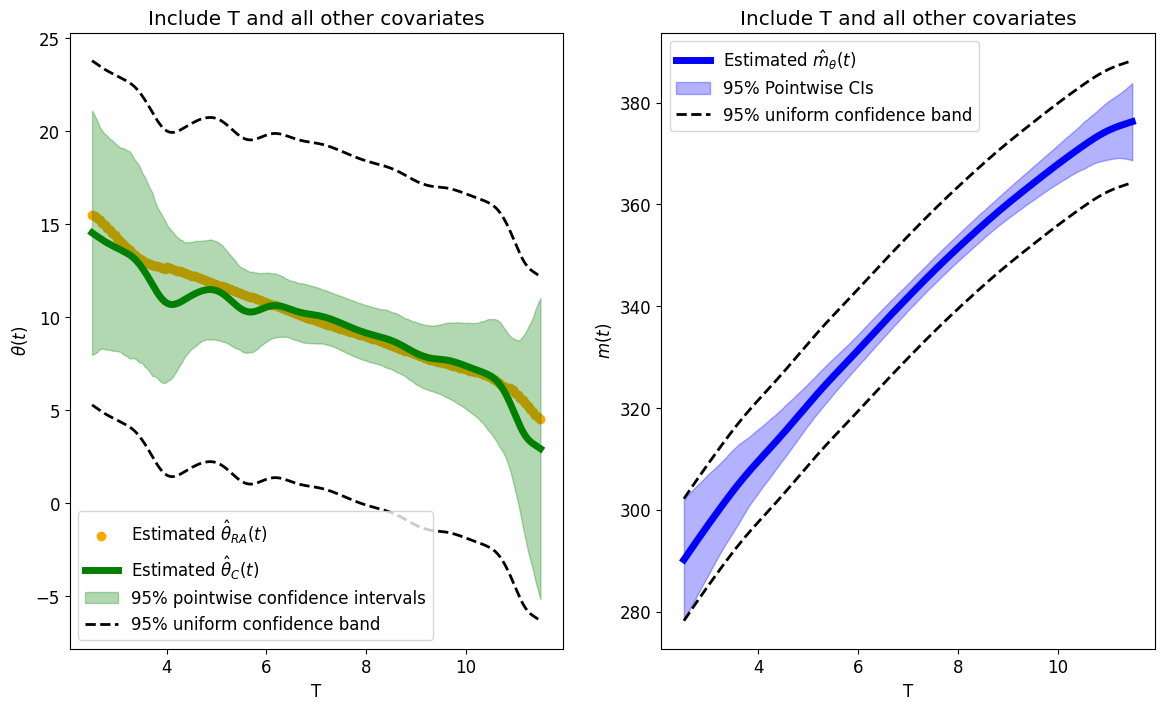

In [34]:
theta_est3r = theta_est3[cri_in]
m_est3r = m_est3[cri_in]
t_qry3r = t_qry[cri_in]
Y_RA_deriv3r = Y_RA_deriv3[cri_in]
Y_RA3r = Y_RA3[cri_in]

plt.rcParams.update({'font.size': 12})  # Change the font sizes of ouput figures
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.scatter(t_qry3r, Y_RA_deriv3r, color='orange', label=r'Estimated $\hat{\theta}_{RA}(t)$')
plt.plot(t_qry3r, theta_est3r, color='green', linewidth=5, label=r'Estimated $\hat{\theta}_C(t)$')
plt.fill_between(t_qry3r, theta_est3r - theta_alpha_var3r, theta_est3r + theta_alpha_var3r, color='g', 
                 alpha=.3, label='95% pointwise confidence intervals')
plt.plot(t_qry3r, theta_est3r - theta_alpha3r, linestyle='dashed', color='black', linewidth=2)
plt.plot(t_qry3r, theta_est3r + theta_alpha3r, linestyle='dashed', color='black', linewidth=2,
         label='95% uniform confidence band')
plt.legend()
plt.xlabel('T')
plt.ylabel(r'$\theta(t)$')
plt.title("Include T and all other covariates")

plt.subplot(122)
# plt.scatter(T, Y, facecolors='none', edgecolors='black', alpha=0.5, label='Noisy data points')
# sns.rugplot(T, height=0.025, color='grey')
# plt.scatter(t_qry3r, Y_RA3r, color='purple', label=r'Estimated $\hat{m}_{RA}(t)$')
plt.plot(t_qry3r, m_est3r, color='blue', linewidth=5, label=r'Estimated $\hat{m}_{\theta}(t)$')
plt.fill_between(t_qry3r, m_est3r - m_alpha_var3r, m_est3r + m_alpha_var3r, color='b', 
                 alpha=.3, label='95% Pointwise CIs')
plt.plot(t_qry3r, m_est3r - m_alpha3r, linestyle='dashed', color='black', linewidth=2)
plt.plot(t_qry3r, m_est3r + m_alpha3r, linestyle='dashed', color='black', linewidth=2,
         label='95% uniform confidence band')
plt.legend()
# plt.xlim(-2, 3)
plt.xlabel('T')
plt.ylabel(r'$m(t)$')
plt.title("Include T and all other covariates")
plt.show()

### Final Figures

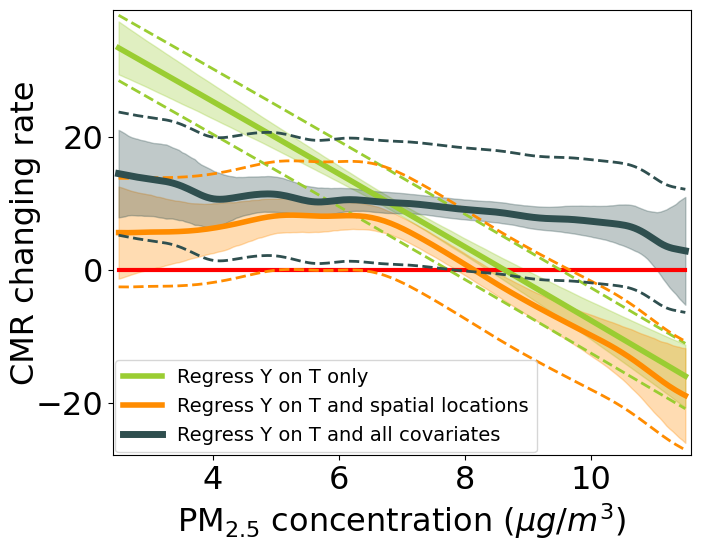

In [35]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5, 6))
plt.plot(t_qry3r, np.zeros_like(t_qry3r), color='red', linewidth=3)

plt.plot(t_qry2r, theta_est2r, linewidth=4, color='yellowgreen', label='Regress Y on T only')
plt.fill_between(t_qry2r, theta_est2r - theta_alpha_var2r, theta_est2r + theta_alpha_var2r, 
                 color='yellowgreen', alpha=.3)
plt.plot(t_qry2r, theta_est2r - theta_alpha2r, linestyle='dashed', color='yellowgreen', linewidth=2)
plt.plot(t_qry2r, theta_est2r + theta_alpha2r, linestyle='dashed', color='yellowgreen', linewidth=2)


plt.plot(t_qry1r, theta_est1r, linewidth=4, color='darkorange', label='Regress Y on T and spatial locations')
plt.fill_between(t_qry1r, theta_est1r - theta_alpha_var1r, theta_est1r + theta_alpha_var1r, 
                 color='darkorange', alpha=.3)
plt.plot(t_qry1r, theta_est1r - theta_alpha1r, linestyle='dashed', color='darkorange', linewidth=2)
plt.plot(t_qry1r, theta_est1r + theta_alpha1r, linestyle='dashed', color='darkorange', linewidth=2)


plt.plot(t_qry3r, theta_est3r, linewidth=5, color='darkslategray', label='Regress Y on T and all covariates')
plt.fill_between(t_qry3r, theta_est3r - theta_alpha_var3r, theta_est3r + theta_alpha_var3r, 
                 color='darkslategray', alpha=.3)
plt.plot(t_qry3r, theta_est3r - theta_alpha3r, linestyle='dashed', color='darkslategray', linewidth=2)
plt.plot(t_qry3r, theta_est3r + theta_alpha3r, linestyle='dashed', color='darkslategray', linewidth=2)

plt.legend(fontsize=14, loc='lower left', bbox_to_anchor=(-0.013, -0.016))
plt.xlabel('PM$_{2.5}$ concentration ($\mu g/m^3$)')
plt.ylabel('CMR changing rate', labelpad=-4)
plt.margins(x=0.01, y=0.012)
plt.tight_layout()
plt.savefig('./Figures/PM25_theta.pdf', bbox_inches='tight')

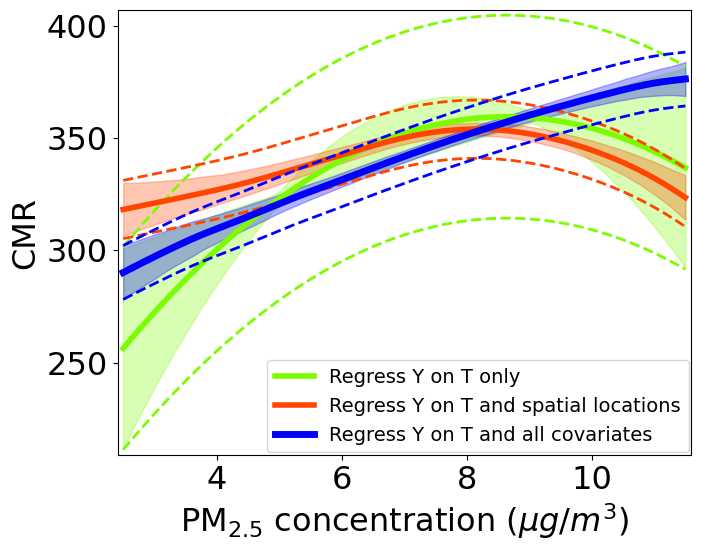

In [36]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5, 6))
plt.plot(t_qry2r, m_est2r, linewidth=4, color='lawngreen', label='Regress Y on T only')
plt.fill_between(t_qry2r, m_est2r - m_alpha_var2r, m_est2r + m_alpha_var2r, 
                 color='lawngreen', alpha=.3)
plt.plot(t_qry2r, m_est2r - m_alpha2r, linestyle='dashed', color='lawngreen', linewidth=2)
plt.plot(t_qry2r, m_est2r + m_alpha2r, linestyle='dashed', color='lawngreen', linewidth=2)


plt.plot(t_qry1r, m_est1r, linewidth=4, color='orangered', label='Regress Y on T and spatial locations')
plt.fill_between(t_qry1r, m_est1r - m_alpha_var1r, m_est1r + m_alpha_var1r, 
                 color='orangered', alpha=.3)
plt.plot(t_qry1r, m_est1r - m_alpha1r, linestyle='dashed', color='orangered', linewidth=2)
plt.plot(t_qry1r, m_est1r + m_alpha1r, linestyle='dashed', color='orangered', linewidth=2)


plt.plot(t_qry3r, m_est3r, linewidth=5, color='blue', label='Regress Y on T and all covariates')
plt.fill_between(t_qry3r, m_est3r - m_alpha_var3r, m_est3r + m_alpha_var3r, 
                 color='blue', alpha=.3)
plt.plot(t_qry3r, m_est3r - m_alpha3r, linestyle='dashed', color='blue', linewidth=2)
plt.plot(t_qry3r, m_est3r + m_alpha3r, linestyle='dashed', color='blue', linewidth=2)

plt.legend(fontsize=14, loc='lower right', bbox_to_anchor=(1.013, -0.016))
plt.xlabel('PM$_{2.5}$ concentration ($\mu g/m^3$)')
plt.ylabel('CMR')
plt.margins(x=0.01, y=0.012)
plt.tight_layout()
plt.savefig('./Figures/PM25_m.pdf', bbox_inches='tight')